In [ ]:
# Imports
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

### Visualize Data Sample

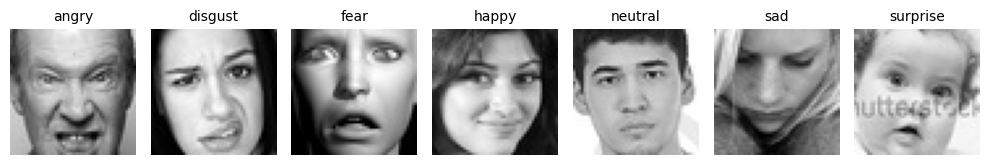

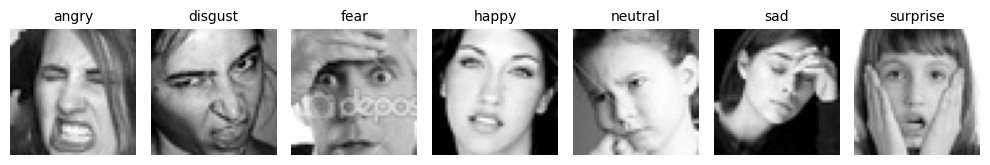

In [4]:
# Define directories
train_data_dir = 'fer2013/train'
val_data_dir = 'fer2013/val'

# Function to display an image from each folder
def display_images_from_folder(directory):
    # Get all subfolders in the directory
    subfolders = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
    cols = len(subfolders)
    plt.figure(figsize=(10, 10))
    
    index = 1
    for folder in subfolders:
        folder_path = os.path.join(directory, folder)
        # Get a list of all images in the folder
        image_files = os.listdir(folder_path)
        image_path = os.path.join(folder_path, random.choice(image_files))
        
        # Open the image using PIL and convert to grayscale
        img = Image.open(image_path).convert('L')
        img = np.array(img)  # Convert the image to a NumPy array
        
        # Plot the image
        plt.subplot(1, cols, index)
        plt.imshow(img, cmap=plt.cm.gray)
        plt.title(folder, fontsize=10)
        plt.axis('off')
        index += 1

    # Display the figure with all the images
    plt.tight_layout() # Adjust spacing between subplots
    plt.show()

# Display images from each directory
display_images_from_folder(train_data_dir)
display_images_from_folder(val_data_dir)


### Data Loading and Pre Processing

In [83]:
BATCH_SIZE = 64
INPUT_SIZE = (224, 224)

# Data generators
train_datagen = ImageDataGenerator(preprocessing_function=None, horizontal_flip=True)
test_datagen = ImageDataGenerator(preprocessing_function=None)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_data_dir, target_size=INPUT_SIZE,
    batch_size=BATCH_SIZE, class_mode='categorical', color_mode='rgb'
)

val_generator = test_datagen.flow_from_directory(
    val_data_dir, target_size=INPUT_SIZE,
    batch_size=BATCH_SIZE, class_mode='categorical', color_mode='rgb'
)

def preprocess_fer2013(image):
    # Convert grayscale image to RGB by repeating the single channel across 3 channels
    image = np.repeat(image[..., np.newaxis], 3, axis=-1)  # Correctly expand to (224, 224, 3)
    return image

preprocessing_function = preprocess_fer2013

Found 28474 images belonging to 7 classes.
Found 7022 images belonging to 7 classes.


### Load Base Model for Transfer Learning

In [71]:

# Load the base model
base_model = load_model('face_detection.h5', compile=False)

base_model.summary()

net_description = 'mobilenet_face' # checkpoints 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 225, 225, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [72]:
# Get the list of layers in the model
layers = base_model.layers

# Display the last 10 layers and their details
print("\nLast 5 layers details:")
for layer in layers[-5:]:
    print(f"Layer Name: {layer.name}")
    print(f"Layer Type: {layer.__class__.__name__}")
    print(f"Output Shape: {layer.output_shape}")
    print(f"Number of Parameters: {layer.count_params()}")
    print("-" * 50)


Last 5 layers details:
Layer Name: dropout_1
Layer Type: Dropout
Output Shape: (None, 1024)
Number of Parameters: 0
--------------------------------------------------
Layer Name: feats
Layer Type: Dense
Output Shape: (None, 256)
Number of Parameters: 262400
--------------------------------------------------
Layer Name: dropout_2
Layer Type: Dropout
Output Shape: (None, 256)
Number of Parameters: 0
--------------------------------------------------
Layer Name: age_pred
Layer Type: Dense
Output Shape: (None, 100)
Number of Parameters: 25700
--------------------------------------------------
Layer Name: gender_pred
Layer Type: Dense
Output Shape: (None, 1)
Number of Parameters: 257
--------------------------------------------------


### Adjusting the Model

In [73]:
'''
The layers dropout_2, age_pred, and gender_pred are specific to predicting 
age and gender in the original model. Since the task is to adapt this model 
for predicting facial emotions, these layers are unnecessary
'''

# Removing the last layers
# Extracting up to the layer before `dropout_2`
output_layer = base_model.get_layer('feats').output

# Add new dense layer for emotion predictions
emotion_preds = Dense(7, activation='softmax', name='emotion_preds')(output_layer)

# Create the new model
model = Model(inputs=base_model.input, outputs=emotion_preds, name="model_2")

# Compile the new model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the updated model
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 225, 225, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                           

In [77]:
# final layer of new model

# get the final layer in the model
final_layer = model.layers[-1]

# display the final layer details
print(f"Layer Name: {final_layer.name}")
print(f"Layer Type: {final_layer.__class__.__name__}")
print(f"Output Shape: {final_layer.output_shape}")

Layer Name: emotion_preds
Layer Type: Dense
Output Shape: (None, 7)


In [78]:
# Initial Parameters Setup
N_CLASS=val_generator.num_classes
nb_train_samples=train_generator.samples
nb_validation_samples=val_generator.samples
print(N_CLASS,nb_train_samples,nb_validation_samples)

7 28474 7022


In [79]:
# Mapping Class Indices to Class Labels
class_to_idx=val_generator.class_indices
idx_to_class={class_to_idx[cls]:cls for cls in class_to_idx}
print(idx_to_class)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


#### Calculating Class Weights

In [80]:
# Calculating Class Weights (balance the classes that are underrepresented)
(unique, counts) = np.unique(train_generator.classes, return_counts=True)
cw=1/counts
cw/=cw.min()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
print(counts, class_weights, idx_to_class, val_generator.class_indices)

[3995  436 4097 7214 4965 4596 3171] {0: 1.8057571964956194, 1: 16.545871559633028, 2: 1.7608005857944837, 3: 1.0, 4: 1.4529707955689828, 5: 1.5696257615317666, 6: 2.2749921160517186} {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'} {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


#### Model Training

In [81]:

start_epoch=0

# Freez the base model
base_model.trainable=False
for l in base_model.layers:
    l.trainable=False
    
# Compiling the Model
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

#Callbacks
mc = ModelCheckpoint(net_description+'_ft.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_accuracy',patience=3)

FIRST_EPOCHS=3

print(model.input_shape)


(None, 224, 224, 3)


In [84]:
# Start training
hist1=model.fit(
    train_generator, 
    steps_per_epoch=nb_train_samples//BATCH_SIZE, 
    epochs=FIRST_EPOCHS, verbose=1, 
    initial_epoch=0, 
    callbacks=[mc, es], 
    validation_data=val_generator, 
    validation_steps=nb_validation_samples // BATCH_SIZE,
    class_weight=class_weights
    )

Epoch 1/3
443/444 [============================>.] - ETA: 0s - loss: 3.3456 - accuracy: 0.2696
Epoch 1: val_accuracy improved from -inf to 0.32268, saving model to mobilenet_face_ft.h5
444/444 [==============================] - 29s 66ms/step - loss: 3.3450 - accuracy: 0.2696 - val_loss: 1.7808 - val_accuracy: 0.3227
Epoch 2/3
443/444 [============================>.] - ETA: 0s - loss: 3.1651 - accuracy: 0.3172
Epoch 2: val_accuracy improved from 0.32268 to 0.33959, saving model to mobilenet_face_ft.h5
444/444 [==============================] - 28s 64ms/step - loss: 3.1645 - accuracy: 0.3172 - val_loss: 1.7517 - val_accuracy: 0.3396
Epoch 3/3
443/444 [============================>.] - ETA: 0s - loss: 3.0941 - accuracy: 0.3318
Epoch 3: val_accuracy did not improve from 0.33959
444/444 [==============================] - 28s 62ms/step - loss: 3.0943 - accuracy: 0.3316 - val_loss: 1.7413 - val_accuracy: 0.3320


### Unfreeze the Last Layers 

In [25]:
start_epoch=len(hist1.history['loss'])
# Unfreeze the last few layers (top 4 layers)
for layer in base_model.layers[-4:]:
    layer.trainable = True
    
model.load_weights(net_description+'_ft.h5')
model.compile(optimizer=Adam(lr=1e-4,decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

SECOND_EPOCHS=start_epoch+17
mc = ModelCheckpoint(net_description+'_ft.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
#es=EarlyStopping(monitor='val_accuracy',patience=2 )

hist2=model.fit(
    train_generator, 
    steps_per_epoch=train_generator.samples//BATCH_SIZE, 
    epochs=SECOND_EPOCHS, verbose=1, 
    initial_epoch=start_epoch, 
    validation_data=val_generator, 
    validation_steps=val_generator.samples // BATCH_SIZE, 
    callbacks=[mc],class_weight=class_weights
    )

Epoch 4/20


c:\Users\daves\anaconda3\envs\tf_py310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


444/444 [==============================] - ETA: 0s - loss: 2.9128 - accuracy: 0.3799
Epoch 4: val_accuracy improved from -inf to 0.43764, saving model to mobilenet_face_ft.h5
444/444 [==============================] - 31s 68ms/step - loss: 2.9128 - accuracy: 0.3799 - val_loss: 1.5388 - val_accuracy: 0.4376
Epoch 5/20
444/444 [==============================] - ETA: 0s - loss: 2.6499 - accuracy: 0.4447
Epoch 5: val_accuracy improved from 0.43764 to 0.48939, saving model to mobilenet_face_ft.h5
444/444 [==============================] - 29s 66ms/step - loss: 2.6499 - accuracy: 0.4447 - val_loss: 1.4044 - val_accuracy: 0.4894
Epoch 6/20
443/444 [============================>.] - ETA: 0s - loss: 2.4960 - accuracy: 0.4772
Epoch 6: val_accuracy improved from 0.48939 to 0.50100, saving model to mobilenet_face_ft.h5
444/444 [==============================] - 30s 68ms/step - loss: 2.4964 - accuracy: 0.4773 - val_loss: 1.3546 - val_accuracy: 0.5010
Epoch 7/20
443/444 [============================

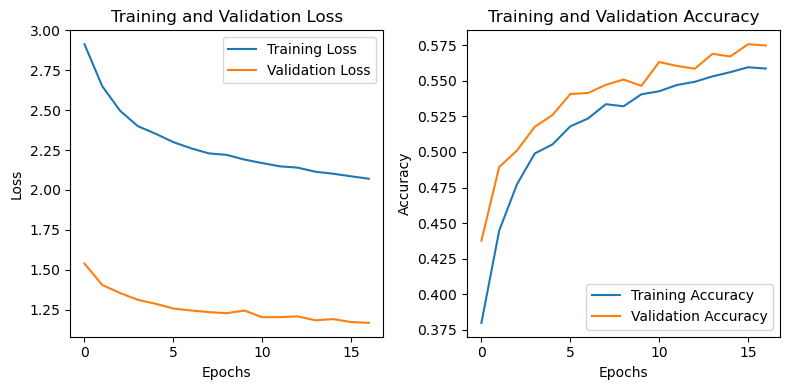

In [26]:
# Extracting training and validation loss and accuracy from history
history = hist2.history

# Plotting training and validation loss
plt.figure(figsize=(8, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

### Fulley Unfreezed Train

In [ ]:
start_epoch=len(hist2.history['loss'])
for l in base_model.layers:
    l.trainable=True
    
model.load_weights(net_description+'_ft.h5')
model.compile(optimizer=Adam(lr=1e-4,decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])


c:\Users\daves\anaconda3\envs\tf_py310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [20]:

SECOND_EPOCHS=start_epoch+10
mc = ModelCheckpoint(net_description+'_ft.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
#es=EarlyStopping(monitor='val_accuracy',patience=2 )

hist3=model.fit(
    train_generator, 
    steps_per_epoch=train_generator.samples//BATCH_SIZE, 
    epochs=SECOND_EPOCHS, verbose=1, 
    initial_epoch=start_epoch, 
    validation_data=val_generator, 
    validation_steps=val_generator.samples // BATCH_SIZE, 
    callbacks=[mc],class_weight=class_weights
    )

Epoch 18/27
444/444 [==============================] - ETA: 0s - loss: 1.8238 - accuracy: 0.6208
Epoch 18: val_accuracy improved from -inf to 0.63876, saving model to mobilenet_face_ft.h5
444/444 [==============================] - 79s 172ms/step - loss: 1.8238 - accuracy: 0.6208 - val_loss: 0.9844 - val_accuracy: 0.6388
Epoch 19/27
444/444 [==============================] - ETA: 0s - loss: 1.5385 - accuracy: 0.6685
Epoch 19: val_accuracy improved from 0.63876 to 0.65783, saving model to mobilenet_face_ft.h5
444/444 [==============================] - 76s 170ms/step - loss: 1.5385 - accuracy: 0.6685 - val_loss: 0.9507 - val_accuracy: 0.6578
Epoch 20/27
444/444 [==============================] - ETA: 0s - loss: 1.3974 - accuracy: 0.6931
Epoch 20: val_accuracy improved from 0.65783 to 0.66829, saving model to mobilenet_face_ft.h5
444/444 [==============================] - 75s 170ms/step - loss: 1.3974 - accuracy: 0.6931 - val_loss: 0.9238 - val_accuracy: 0.6683
Epoch 21/27
444/444 [=======

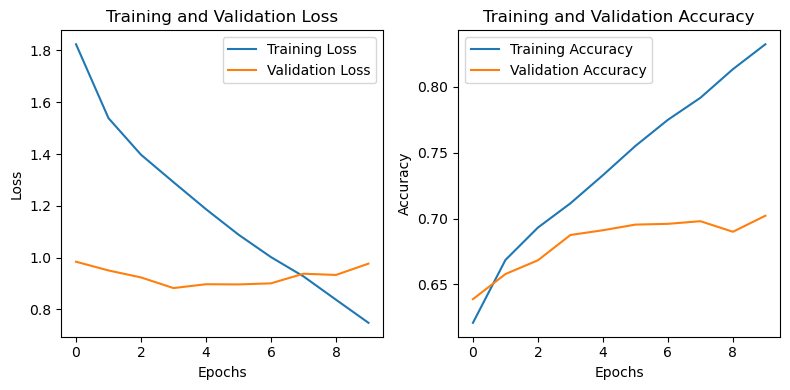

In [21]:
# Extracting training and validation loss and accuracy from history
history = hist3.history

# Plotting training and validation loss
plt.figure(figsize=(8, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

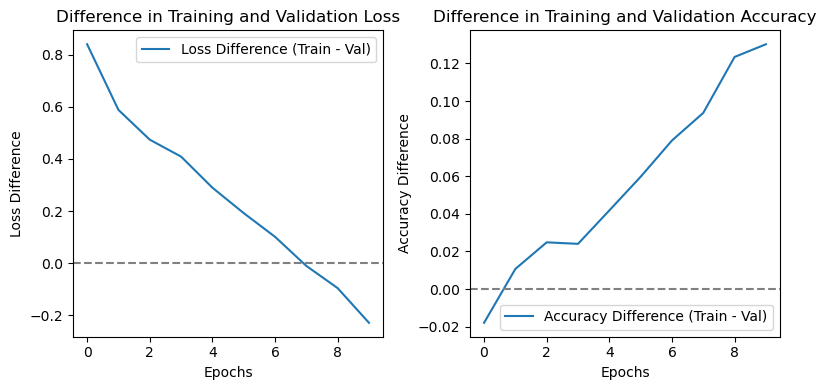

In [82]:
plt.figure(figsize=(8, 4))

# Difference between training and validation loss
plt.subplot(1, 2, 1)
loss_diff = np.array(history['loss']) - np.array(history['val_loss'])
plt.plot(loss_diff, label='Loss Difference (Train - Val)')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Difference in Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Difference')
plt.legend()

# Difference between training and validation accuracy
plt.subplot(1, 2, 2)
acc_diff = np.array(history['accuracy']) - np.array(history['val_accuracy'])
plt.plot(acc_diff, label='Accuracy Difference (Train - Val)')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Difference in Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Difference')
plt.legend()

plt.tight_layout()
plt.show()


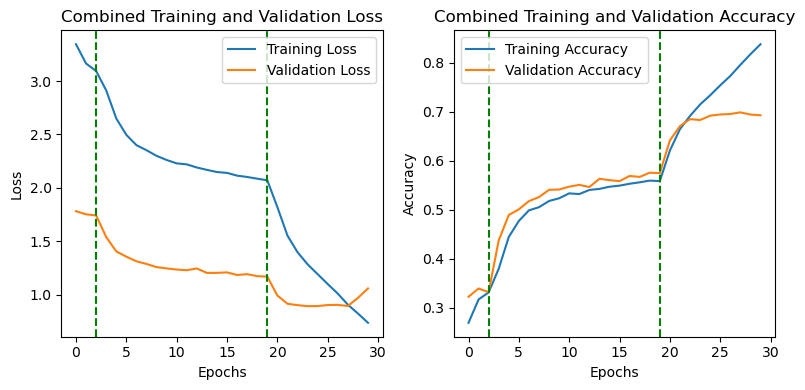

In [104]:

# Assuming hist1, hist2, hist3 are the history objects from the three training runs
history1 = hist1.history
history2 = hist2.history
history3 = hist3.history

# Combine the histories by concatenating loss and accuracy values
combined_loss = history1['loss'] + history2['loss'] + history3['loss']
combined_val_loss = history1['val_loss'] + history2['val_loss'] + history3['val_loss']
combined_accuracy = history1['accuracy'] + history2['accuracy'] + history3['accuracy']
combined_val_accuracy = history1['val_accuracy'] + history2['val_accuracy'] + history3['val_accuracy']

# Define the epoch num where it saved the best models (not the number of epochs)
change_point_1 = 2
change_point_2 = 19

# Create a plot for combined training and validation loss
plt.figure(figsize=(8, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(combined_loss, label='Training Loss')
plt.plot(combined_val_loss, label='Validation Loss')
plt.title('Combined Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.axvline(x=change_point_1, color='g', linestyle='--', label='History Change')
plt.axvline(x=change_point_2, color='g', linestyle='--', label='History Change')


# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(combined_accuracy, label='Training Accuracy')
plt.plot(combined_val_accuracy, label='Validation Accuracy')
plt.title('Combined Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.axvline(x=change_point_1, color='g', linestyle='--')
plt.axvline(x=change_point_2, color='g', linestyle='--')

# Show the plots
plt.tight_layout()
plt.show()


### Evaluation

1/1 [==============================] - 0s 20ms/step
Overall Accuracy: 80.28%


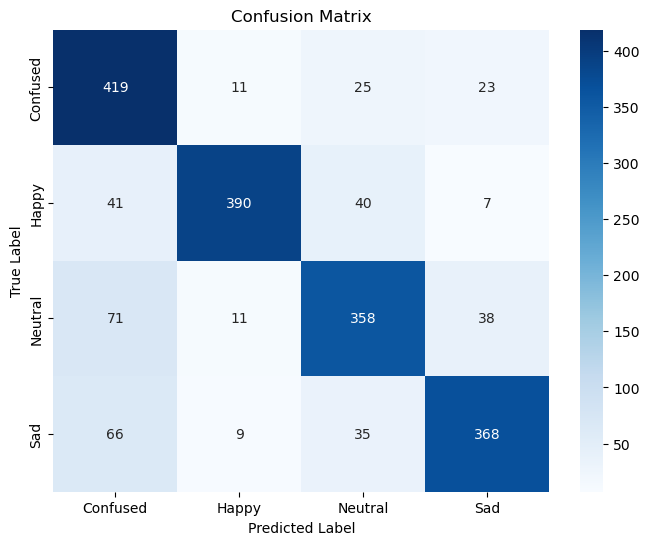

Accuracy for Confused: 87.66%
Accuracy for Happy: 81.59%
Accuracy for Neutral: 74.90%
Accuracy for Sad: 76.99%


In [182]:

# Load trained model for facial emotion recognition
model_best = load_model('mobilenet_face_ft.h5')  # Current best model

# Trained emotions:
class_names = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# Map Classes for the three emotional states
emotion_mapping = {
    'Anger': 'Confused', 
    'Disgust': 'Confused', 
    'Fear': 'Confused', 
    'Happiness': 'Happy', 
    'Neutral': 'Neutral', 
    'Sadness': 'Sad', 
    'Surprise': 'Confused'
}

image_folder = 'test/'  # folder path

# Initialize dictionaries to collect images for each mapped class
class_image_paths = {'Confused': [], 'Happy': [], 'Neutral': [], 'Sad': []}

# Collect image paths grouped by the mapped class
for label_folder in os.listdir(image_folder):
    subfolder_path = os.path.join(image_folder, label_folder)
    
    # Check if the folder is a directory and if the folder name is numeric
    if os.path.isdir(subfolder_path) and label_folder.isdigit():
        # Map the folder name to the corresponding emotion label
        emotion_label = class_names[int(label_folder)]
        mapped_emotion_label = emotion_mapping[emotion_label]

        # Get the list of image files in the subfolder
        image_files = [os.path.join(subfolder_path, f) for f in os.listdir(subfolder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
        class_image_paths[mapped_emotion_label].extend(image_files)

#Determine the minimum number of images for any class
min_images = min(len(class_image_paths['Confused']), len(class_image_paths['Happy']),
                 len(class_image_paths['Neutral']), len(class_image_paths['Sad']))

# Limit each class to the same number of images (minimum count)
selected_image_paths = {key: random.sample(paths, min_images) for key, paths in class_image_paths.items()}

# Initialize lists for true labels and predicted labels
true_labels = []
predicted_labels = []

# Process selected images
for class_name, image_paths in selected_image_paths.items():
    for img_path in image_paths:
        # Load the image
        img = cv2.imread(img_path)

        # Resize the face image to the required input size for the model
        face_image = cv2.resize(img, (224, 224))  # Change to 224x224
        face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)  # Convert to RGB (if BGR)
        face_image = image.img_to_array(face_image)  # Convert to array
        face_image = np.expand_dims(face_image, axis=0)  # Add batch dimension

        # Predict emotion using the loaded model
        predictions = model_best.predict(face_image)

        # Get the maximum prediction probability and its corresponding label index
        max_prob = np.max(predictions)
        max_index = np.argmax(predictions)

        predicted_emotion = class_names[max_index]
        mapped_predicted_emotion = emotion_mapping[predicted_emotion]

        # Append the true label and predicted label
        true_labels.append(class_name)
        predicted_labels.append(mapped_predicted_emotion)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Overall Accuracy: {accuracy * 100:.2f}%')

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Confused', 'Happy', 'Neutral', 'Sad'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Confused', 'Happy', 'Neutral', 'Sad'], yticklabels=['Confused', 'Happy', 'Neutral', 'Sad'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Class accuracies
class_accuracies = {}
for class_name in ['Confused', 'Happy', 'Neutral', 'Sad']:
    # Calculate the accuracy for each class
    class_true_labels = [true_labels[i] for i in range(len(true_labels)) if true_labels[i] == class_name]
    class_predicted_labels = [predicted_labels[i] for i in range(len(predicted_labels)) if true_labels[i] == class_name]
    
    if len(class_true_labels) > 0:
        class_accuracy = accuracy_score(class_true_labels, class_predicted_labels)
        class_accuracies[class_name] = class_accuracy

# Print class-wise accuracies
for class_name, class_accuracy in class_accuracies.items():
    print(f'Accuracy for {class_name}: {class_accuracy * 100:.2f}%')


#### Testing with single image

In [144]:

# Load trained model for facial emotion recognition
model_best = load_model('mobilenet_face_ft.h5') # Current best model

# Trained emotions:
class_names = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# Load the image you want to process
img_path = 'test/3/test_0166_aligned.jpg'
img = cv2.imread(img_path)

# Resize the face image to the required input size for the model
face_image = cv2.resize(img, (224, 224))  # Change to 224x224
face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)  # Convert to RGB (if BGR)
face_image = image.img_to_array(face_image)  # Convert to array
face_image = np.expand_dims(face_image, axis=0)  # Add batch dimension

# Predict emotion using the loaded model
predictions = model_best.predict(face_image)

# Get the maximum prediction probability and its corresponding label index
max_prob = np.max(predictions)
max_index = np.argmax(predictions)

emotion_label = class_names[max_index]


# Print the detected emotion
print(f'Detected Emotion: {emotion_label}')


1/1 [==============================] - 0s 326ms/step
Detected Emotion: Happiness
